## Initialisation

In [1]:
import random
import time
import pprint

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

## Generation Villes & Routes

In [164]:
def generate_cities(n):
    collection_villes.drop()
    collection_routes.drop()

    cities = []
    roads = []

    #start = time.perf_counter()

    for i in range(1, n + 1):
        cities.append({"id_ville": i})
        for j in range(i - 1, -1, -1):
            if random.random() > 0.95: roads.append({"route": "route " + str(i) + "/" + str(j),"id_ville_1": i,"id_ville_2": j,"est_oriente": True,"poids_1": int(random.random() * 590 + 10),"poids_2": int(random.random() * 590 + 10),"trafic": [random.random() * 0.50 + 0.50 for _ in range(0, 24, 4)]})
            else: roads.append({"route": "route " + str(i) + "/" + str(j),"id_ville_1": i,"id_ville_2": j,"est_oriente": False,"poids": int(random.random() * 590 + 10),"trafic": [random.random() * 0.50 + 0.50 for _ in range(0, 24, 4)]})
        if len(roads) >= 1000:
            collection_routes.insert_many(roads)
            roads = []
    collection_villes.insert_many(cities)
    if roads: collection_routes.insert_many(roads)

    #print(time.perf_counter() - start)


generate_cities(1000)

## Generation Clients


In [165]:
def generate_clients(n):
    collection_clients.drop()
    clients = []

    for i in range(1, n + 1):
        client = {"id_client" : i, 'est_client': True}
        if random.random() > 0.5:
            randomizer = random.random()
            if randomizer < 0.33:
                client['type'] = 'particulier'
                clients.append(client)
            elif randomizer < 0.66:
                client['type'] = 'frais'
                clients.append(client)
            else:
                client['type'] = 'prisonnier'
                clients.append(client)
        else:
            client['est_client'] = False
            clients.append(client)
    collection_clients.insert_many(clients)

generate_clients(collection_villes.count_documents({}))


## Import Graphe

In [166]:
num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

## Fonction Voisin

In [4]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = circuit.copy()
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

test_circuit = [0,2,18,20,32,37,0]
print(f'origine : {test_circuit}')
for n in neighborhood(test_circuit):
    print(f'voisin  : {n}')

origine : [0, 2, 18, 20, 32, 37, 0]
voisin  : [0, 18, 2, 20, 32, 37, 0]
voisin  : [0, 2, 20, 18, 32, 37, 0]
voisin  : [0, 2, 18, 32, 20, 37, 0]
voisin  : [0, 2, 18, 20, 37, 32, 0]


## Fonction Recuperation Routes

In [6]:
def import_roads(cities):
     return np.array(list(collection_routes.find({'id_ville_1': {'$in': cities}, 'id_ville_2': {'$in': cities}})))


## Fonction Score

In [7]:
def circuit_score(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

test_circuit = [0,2,18,20,32,37,0]
test_roads = import_roads(test_circuit)

for neighbor in neighborhood(test_circuit):
    print(circuit_score(neighbor, test_roads))

1616
1651
2037
1349


## Recherche Tabou

In [31]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads):
    iteration = 1
    tabu_list = list()
    actual_circuit = initial_circuit.copy()

    best_actual_circuit = initial_circuit.copy()
    best_total_circuit = initial_circuit.copy()
    best_total_value = circuit_score(best_total_circuit, actual_roads)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if neighbor not in tabu_list and (circuit_score(neighbor, actual_roads) <= best_actual_value or best_actual_value == -1):
                best_actual_value = circuit_score(neighbor, actual_roads)
                best_actual_circuit = neighbor.copy()

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = best_actual_circuit.copy()
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = best_actual_circuit.copy()

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(actual_circuit.copy())

    return best_total_circuit, best_total_list, best_actual_list

[0, 18, 2, 20, 37, 32, 44, 48, 70, 52, 0]


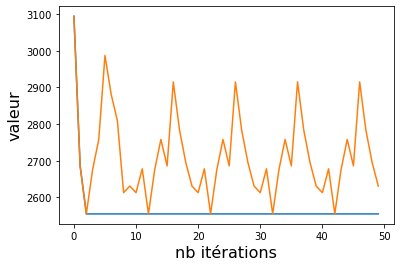

In [171]:
test_circuit = [0,2,18,20,32,37,44,48,52,70,0]


best_circuit, bt, ba= tabu_search(test_circuit, 9, 50)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
print(best_circuit)
res = plt.plot(range(50), bt)
res = plt.plot(range(50), ba)

## Multi-start

[0, 2, 18, 20, 32, 37, 44, 48, 52, 70, 0]
[0, 48, 44, 37, 20, 32, 18, 2, 70, 52, 0]
[0, 48, 52, 2, 70, 44, 32, 18, 20, 37, 0]
[0, 18, 32, 2, 20, 52, 37, 44, 70, 48, 0]
[0, 44, 20, 70, 32, 2, 48, 18, 52, 37, 0]
1649


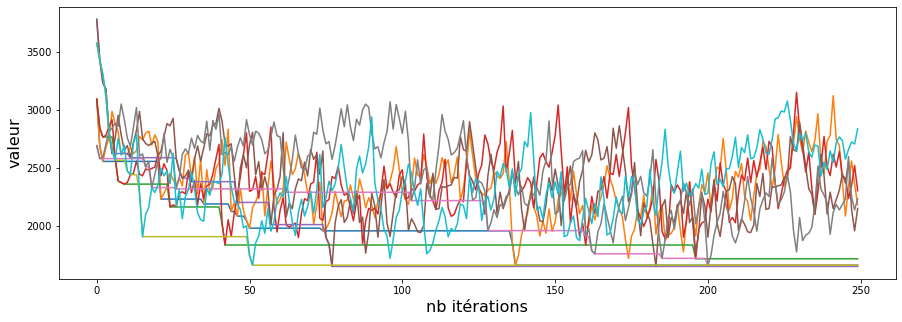

In [33]:
n = 5
test_circuit = [0,2,18,20,32,37,44,48,52,70,0]
shuffled = test_circuit[1:-1]

it = 250

plt.figure(figsize=(15,5))
best = -1


actual_roads = import_roads(test_circuit)

for i in range(0, n):

    shuffled_circuit = shuffled.copy()
    shuffled_circuit.append(0)
    shuffled_circuit.insert(0, 0)
    print(shuffled_circuit)
    bc, bt, ba= tabu_search(shuffled_circuit, 100, it, actual_roads)
    actual_score = circuit_score(bc, actual_roads)
    if best == -1 or actual_score < best:
        best = actual_score
    plt.xlabel("nb itérations", fontsize=16)
    plt.ylabel("valeur", fontsize=16)
    res = plt.plot(range(it), bt)
    res = plt.plot(range(it), ba)

    random.shuffle(shuffled)
print(best)